<a href="https://colab.research.google.com/github/Shujaat123/Weather_Classification/blob/master/Image_Segmentation_Dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install nibabel


In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os
import nibabel as nib
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle

class NiiDataGenerator(Sequence):
    def __init__(self, images_dir, batch_size=4, dim=(128, 128, 128), n_channels=1, shuffle=True):
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.file_paths = [os.path.join(images_dir, fname) for fname in os.listdir(images_dir) if fname.endswith('.nii.gz')]
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X = self._generate_data(batch_files)
        return X

    def on_epoch_end(self):
        # Shuffle file paths after each epoch
        if self.shuffle:
            self.file_paths = shuffle(self.file_paths)

    def _generate_data(self, batch_files):
        # Load and preprocess data
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        for i, file_path in enumerate(batch_files):
            img = nib.load(file_path).get_fdata()
            # Resize to desired dimension
            img = np.resize(img, self.dim)  # Or use another resizing method if necessary
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            X[i,] = img
        return X


In [18]:
# Step 2: Function to load all .nii.gz files in the folder and return a tensor
def load_all_nii_to_tensor(folder_path):
    # Get the list of all .nii.gz files in the directory
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.nii.gz')])

    if not file_list:
        print("No .nii.gz files found in the directory.")
        return None

    # Initialize an empty list to store the individual tensors
    tensors = []

    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        img = nib.load(file_path)
        img_data = img.get_fdata()  # Convert to NumPy array

        # Optionally, normalize the data
        img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

        # Convert to a PyTorch tensor and add a channel dimension
        img_tensor = torch.tensor(img_data, dtype=torch.float32).unsqueeze(0)  # Shape: (1, H, W, D)
        tensors.append(img_tensor)

    # Stack all tensors along the first dimension (batch dimension)
    all_tensors = torch.stack(tensors)

    return all_tensors

# Example usage
data_dir = "/content/drive/My Drive/COE589/Task02_Heart/imagesTr"
all_img_tensors = load_all_nii_to_tensor(data_dir)

# Check if tensors were loaded successfully and print the shape
if all_img_tensors is not None:
    print("Tensor shape (batch, channel, height, width, depth):", all_img_tensors.shape)
    print("Tensor type:", all_img_tensors.dtype)


Tensor shape (batch, channel, height, width, depth): torch.Size([1, 1, 320, 320, 110])
Tensor type: torch.float32


In [22]:
import os
import torch
import numpy as np
from PIL import Image

def save_slices_as_png(tensor, save_dir):
    os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

    # Unpack the tensor dimensions
    batch_size, channels, height, width, depth = tensor.shape

    # Loop through each volume in the batch
    for i in range(batch_size):
        # Loop through each slice in the depth dimension
        for j in range(depth):
            # Extract the 2D slice
            slice_2d = tensor[i, 0, :, :, j].numpy()  # Convert to numpy array

            # Normalize to [0, 255] for saving as PNG
            slice_2d = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min()) * 255
            slice_2d = slice_2d.astype(np.uint8)

            # Convert to PIL Image
            img = Image.fromarray(slice_2d)

            # Create a filename with volume and slice index
            file_name = f"volume_{i}_slice_{j}.png"
            file_path = os.path.join(save_dir, file_name)

            # Save the slice as a PNG
            img.save(file_path)

# Example usage
save_dir = "/content/drive/My Drive/COE589/Task02_Heart/slices"  # Change to your desired output directory
save_slices_as_png(all_img_tensors, save_dir)


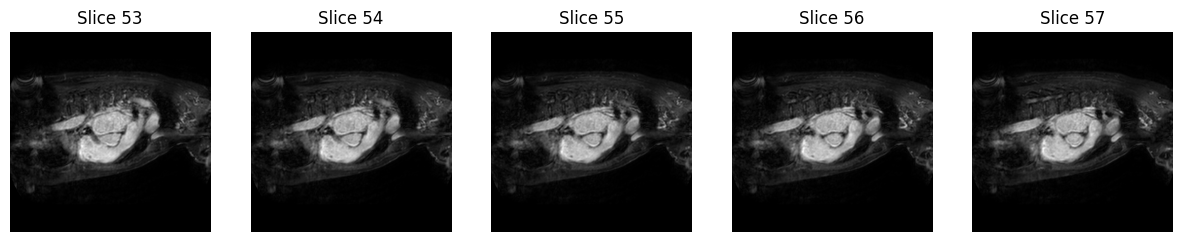

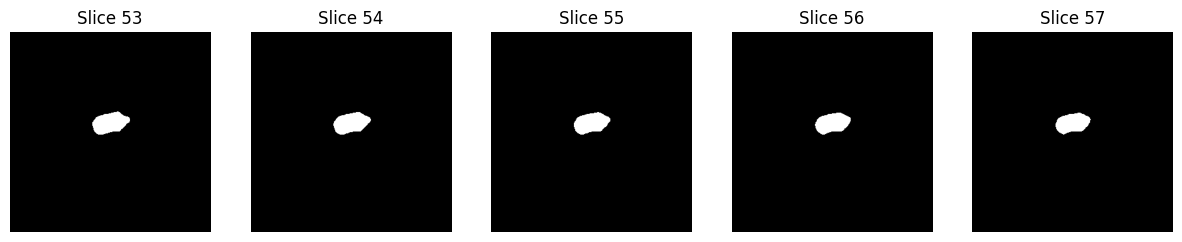

In [19]:
import matplotlib.pyplot as plt

def show_sample_scan(data_dir):
    # Load one sample file
    sample_file = os.listdir(data_dir)[0]  # pick the first file in the directory
    sample_path = os.path.join(data_dir, sample_file)
    img = nib.load(sample_path).get_fdata()

    # Display a few slices in the middle of the scan
    num_slices = img.shape[2]  # assuming last dimension is the number of slices
    mid_slice = num_slices // 2

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        slice_idx = mid_slice - 2 + i  # display 5 slices around the middle
        ax.imshow(img[:, :, slice_idx], cmap="gray")
        ax.axis('off')
        ax.set_title(f"Slice {slice_idx}")
    plt.show()

# Update the path to point to your Google Drive folder
data_dir = "/content/drive/My Drive/COE589/Task02_Heart/imagesTr"
label_dir = "/content/drive/My Drive/COE589/Task02_Heart/labelsTr"

# Use the function to visualize a sample scan
show_sample_scan(data_dir)
show_sample_scan(label_dir)
